# 機械学習　第８章　実習問題（回帰）
## －大学で学んだ「計量経済学」で宿題をやってみたの巻ー

## ※ 準備作業

In [ ]:
!pip install japanize-matplotlib

In [22]:
import pandas as pd
import numpy as np #データ加工用に追加
from sklearn.model_selection import train_test_split
import japanize_matplotlib #日本語フォント表示用
%matplotlib inline

In [23]:
df = pd.read_csv('house_rent.csv', header=0, encoding='cp932')
df.head()

,所在地,家賃(円),敷金(か月),礼金(か月）,面積(㎡),築年数(年),駅徒歩分,間取,方位,構造
0,市川市真間,60000,1,1.0,23.15,19.0,7.0,1K,南,軽量鉄骨
1,市川市新田,77000,2,1.0,23.19,16.0,2.0,1K,南東,木造
2,市川市市川南,65500,1,1.0,NaN,20.0,6.0,1K,西,木造
3,市川市大洲,65000,2,1.0,28.92,120.0,10.0,1DK,南東,木造
4,市川市真間,60000,1,1.0,32.05,19.0,10.0,1DK,南,木造


## 先にダミー変数作成、欠損値処理、外れ値処理を行ってしまいます。

In [24]:
df2 = pd.get_dummies(df, drop_first = True)
df2.head()

,家賃(円),敷金(か月),礼金(か月）,面積(㎡),築年数(年),駅徒歩分,所在地_市川市大洲,所在地_市川市大町,所在地_市川市市川,所在地_市川市市川南,所在地_市川市平田,所在地_市川市新田,所在地_市川市真間,所在地_市川市菅野,所在地_市川市須和田,間取_1K,間取_1R,方位_北東,方位_南,方位_南東,方位_南西,方位_東,方位_西,構造_軽量鉄骨,構造_鉄骨造
0,60000,1,1.0,23.15,19.0,7.0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,77000,2,1.0,23.19,16.0,2.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,65500,1,1.0,NaN,20.0,6.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,65000,2,1.0,28.92,120.0,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60000,1,1.0,32.05,19.0,10.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [93]:
df2_mean = df2.mean() # 各列の平均値の計算
df2=df2.fillna(df2_mean) # 平均値で穴埋め
df2.head()

,家賃(円),敷金(か月),礼金(か月）,面積(㎡),築年数(年),駅徒歩分,所在地_市川市大洲,所在地_市川市大町,所在地_市川市市川,所在地_市川市市川南,所在地_市川市平田,所在地_市川市新田,所在地_市川市真間,所在地_市川市菅野,所在地_市川市須和田,間取_1K,間取_1R,方位_北東,方位_南,方位_南東,方位_南西,方位_東,方位_西,構造_軽量鉄骨,構造_鉄骨造,新築,敷金礼金,面積2,log面積
0,60000,1,1.0,23.150000,19.0,7.000000,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,2.0,3.141995,3.141995
1,77000,2,1.0,23.190000,16.0,2.000000,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.0,3.143721,3.143721
2,65500,1,1.0,21.658878,20.0,6.000000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2.0,3.075415,3.075415
4,60000,1,1.0,32.050000,19.0,10.000000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,2.0,3.467297,3.467297
5,57000,1,1.0,19.000000,19.0,8.146179,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2.0,2.944439,2.944439


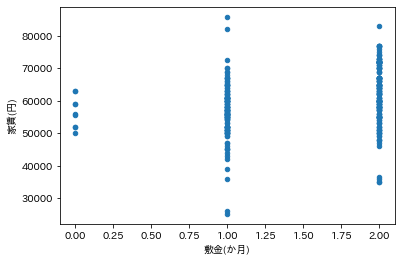

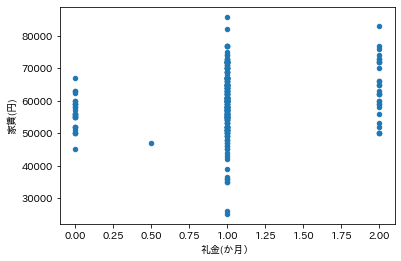

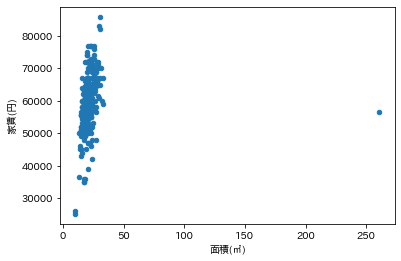

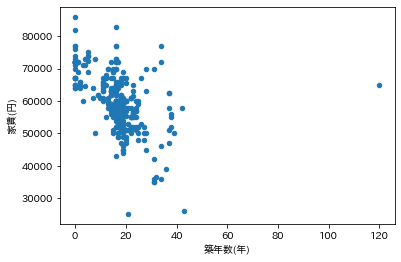

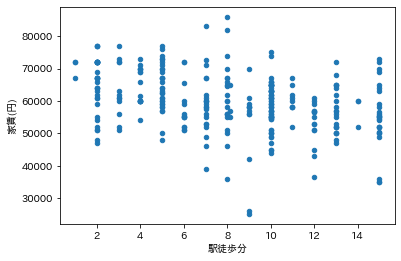

In [26]:
df2.plot(kind = 'scatter', x = '敷金(か月)', y = '家賃(円)')
df2.plot(kind = 'scatter', x = '礼金(か月）', y = '家賃(円)')
df2.plot(kind = 'scatter', x = '面積(㎡)', y = '家賃(円)')
df2.plot(kind = 'scatter', x = '築年数(年)', y = '家賃(円)')
df2.plot(kind = 'scatter', x = '駅徒歩分', y = '家賃(円)')

In [27]:
out_line1 = df2[(df2['面積(㎡)'] > 250)].index #大豪邸
out_line2 = df2[(df2['築年数(年)'] > 100)].index #古民家
print (out_line1, out_line2)

Int64Index([95], dtype='int64') Int64Index([3], dtype='int64')


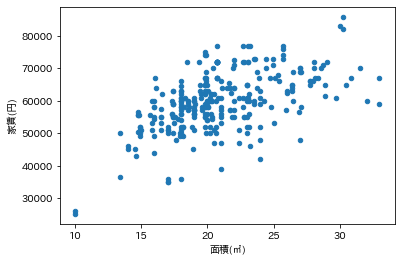

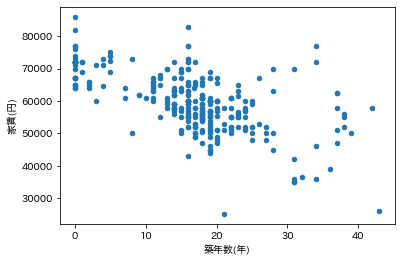

In [28]:
df2 = df2.drop([95], axis = 0)
df2 = df2.drop([3], axis = 0)
df2.plot(kind = 'scatter', x = '面積(㎡)', y = '家賃(円)')
df2.plot(kind = 'scatter', x = '築年数(年)', y = '家賃(円)')

## 一般最小二乗法（OrdinaryLeastSquares）
Y（被説明変数）=a（係数）* X（説明変数） + b（切片） + ε（誤差項）
### 説明変数は「独立変数」とも言い、その名の通りお互いに独立であることが望まれます。
#### ※また、各々正規分布であることが前提となっています
純粋に説明変数（パラメーター）になりうるのは「面積」「築年数」「駅徒歩分」のみですので、これらがお互いに相関のないことを確認します。
####※「敷金」「礼金」については後程加工を行う予定です。

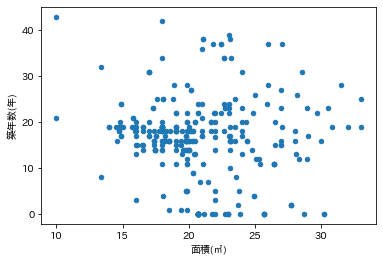

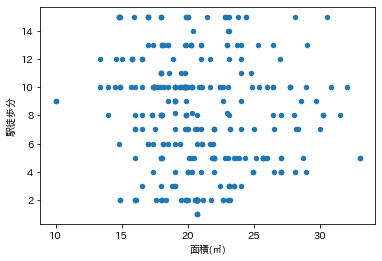

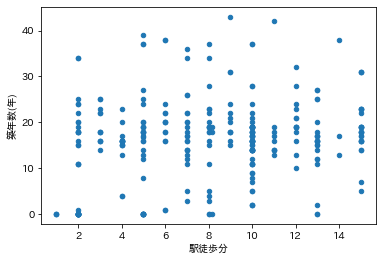

In [29]:
df2.plot(kind = 'scatter', x = '面積(㎡)', y = '築年数(年)')
df2.plot(kind = 'scatter', x = '面積(㎡)', y = '駅徒歩分')
df2.plot(kind = 'scatter', x = '駅徒歩分', y = '築年数(年)')

In [31]:
target = ['面積(㎡)','築年数(年)','駅徒歩分']
df2[target].corr() #相関はなさそうです

,面積(㎡),築年数(年),駅徒歩分
面積(㎡),1.000000,-0.105023,-0.114298
築年数(年),-0.105023,1.000000,0.198845
駅徒歩分,-0.114298,0.198845,1.000000


## ダミー変数の解釈
Y = a * X + d * Xd（ダミー変数） + b（切片） + ε
### ダミー変数とは、特定の条件が揃ったときのみ「1（オン）」となる変数（モドキ）です。
### 特定の条件が揃ったとき、次にのように書き換えることができます。
Y = a * X + d * 1 + b（切片） + ε
### つまり
Y = a * X + (d + b) + ε
### 切片がdだけ増加したことと同じ意味です。
#### 例えば「渋谷というだけで家賃が上がる」等の時にダミー変数は有効です。


### ダミー変数を採用するのは、次のようなコツがあります。
#### ・1（オン）になるサンプルが「そこそこ」存在する
#### ・モデルに入れるのは「ほどほど」に（左手は添えるだけ）
※欲張ると過学習の原因になります

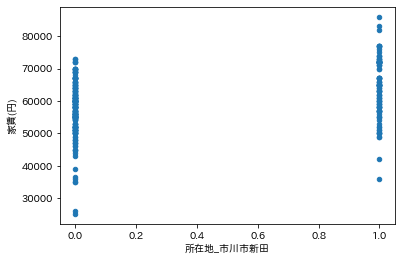

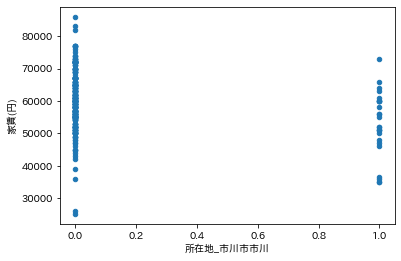

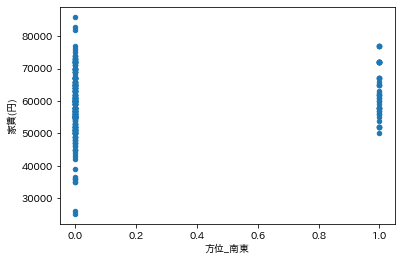

In [38]:
df2.plot(kind = 'scatter', x = '所在地_市川市新田', y = '家賃(円)') # 駅前好立地
df2.plot(kind = 'scatter', x = '所在地_市川市市川', y = '家賃(円)') # 好立地なのに、なぜ？
df2.plot(kind = 'scatter', x = '方位_南東', y = '家賃(円)') # 南向きではダメみたい

In [43]:
target = ['家賃(円)','所在地_市川市新田','所在地_市川市市川','方位_南東']
dummies = df2[target]
dummies.corr()['家賃(円)'] #相関もまぁまぁです

家賃(円)        1.000000
所在地_市川市新田    0.363127
所在地_市川市市川   -0.227988
方位_南東        0.171653
Name: 家賃(円), dtype: float64

## ここまででデータフレームを整理し、分析の準備をします

In [106]:
col = ['家賃(円)', '面積(㎡)', '築年数(年)', '駅徒歩分', '所在地_市川市新田','所在地_市川市市川','方位_南東']
df3 = df2[col]
df3.head()

,家賃(円),面積(㎡),築年数(年),駅徒歩分,所在地_市川市新田,所在地_市川市市川,方位_南東
0,60000,23.150000,19.0,7.000000,0,0,0
1,77000,23.190000,16.0,2.000000,1,0,1
2,65500,21.658878,20.0,6.000000,0,0,0
4,60000,32.050000,19.0,10.000000,0,0,0
5,57000,19.000000,19.0,8.146179,1,0,0


In [107]:
train_val, test = train_test_split(df3,test_size = 0.2,random_state = 0)

In [108]:
col = ['面積(㎡)', '築年数(年)', '駅徒歩分', '所在地_市川市新田','所在地_市川市市川','方位_南東']
x = train_val[col]
t = train_val[['家賃(円)']]

#訓練データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(x, t,test_size = 0.2, random_state = 0)

### 訓練データ、検証データ、テストデータにバラツキがあるのが気になります。

In [104]:
print(x_train.describe())
print(x_val.describe())
print(test[col].describe())
print(y_train.describe())
print(y_val.describe())
print(test['家賃(円)'].describe())

# 検証データでスコアが良くてもテストデータで悪くなる、あるいはその逆が発生しそうです。

            面積(㎡)      築年数(年)        駅徒歩分   所在地_市川市新田   所在地_市川市市川       方位_南東
count  192.000000  192.000000  192.000000  192.000000  192.000000  192.000000
mean    20.855515   15.717581    8.022356    0.343750    0.088542    0.135417
std      4.003787    9.042161    3.965787    0.476201    0.284824    0.343063
min     10.000000    0.000000    1.000000    0.000000    0.000000    0.000000
25%     18.020000   12.000000    5.000000    0.000000    0.000000    0.000000
50%     20.340000   17.000000    8.000000    0.000000    0.000000    0.000000
75%     23.025000   19.250000   10.000000    1.000000    0.000000    0.000000
max     33.000000   39.000000   15.000000    1.000000    1.000000    1.000000
           面積(㎡)     築年数(年)       駅徒歩分  所在地_市川市新田  所在地_市川市市川      方位_南東
count  49.000000  49.000000  49.000000  49.000000  49.000000  49.000000
mean   21.837143  16.795918   8.247881   0.367347   0.061224   0.142857
std     4.240705   8.597431   3.699692   0.487078   0.242226   0.353553
min    14.

In [105]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
model.score(x_val, y_val)
# 結果は悪くないですね(^^)

0.6616530047284529

## 特徴量エンジニアリングを行います
### 私がアパートを借りるなら、次の2点を重要視します
#### ・新築なら家賃が少し高くても我慢します（ダミー変数作成）
#### ・敷金と礼金はどうせ戻ってきません（説明変数の統合）
### また、「面積」「築年数」「駅徒歩分」は、「限界効用逓減の法則」を疑います。
例）「築年数」が新築か築２年は重要だが、築30年と築32年はそれほどでもない
※ビールは1杯目は嬉しいけど、10杯目はウンザリ、的な

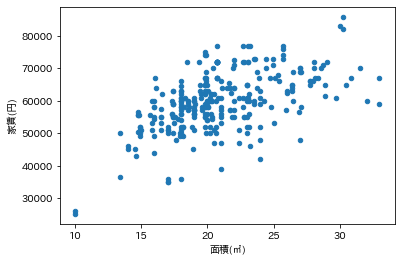

In [62]:
df2.plot(kind = 'scatter', x = '面積(㎡)', y = '家賃(円)') 
# 面積は低減効果がありそうです

In [63]:
work = pd.get_dummies(df2,  drop_first = False, columns=['築年数(年)'])
df2['新築'] = work['築年数(年)_0.0'] #新築ダミー
df2['敷金礼金'] = df2['敷金(か月)'] + df2['礼金(か月）'] #敷金礼金はまとめて
df2['log面積'] = np.log(df3['面積(㎡)']) #面積効果は逓減（そんなに広くてもうれしくない）
col = ['家賃(円)', 'log面積', '新築', '築年数(年)', '駅徒歩分','敷金礼金', '所在地_市川市新田','所在地_市川市市川','方位_南東']
df4 = df2[col]
df4.head()

,家賃(円),log面積,新築,築年数(年),駅徒歩分,敷金礼金,所在地_市川市新田,所在地_市川市市川,方位_南東
0,60000,3.141995,0,19.0,7.000000,2.0,0,0,0
1,77000,3.143721,0,16.0,2.000000,3.0,1,0,1
2,65500,3.075415,0,20.0,6.000000,2.0,0,0,0
4,60000,3.467297,0,19.0,10.000000,2.0,0,0,0
5,57000,2.944439,0,19.0,8.146179,2.0,1,0,0


In [65]:
target = ['家賃(円)','新築','敷金礼金','log面積']
values = df4[target]
values.corr()['家賃(円)'] #相関もよさそうです

家賃(円)    1.000000
新築       0.421236
敷金礼金     0.306036
log面積    0.569028
Name: 家賃(円), dtype: float64

In [162]:
train_val, test = train_test_split(df4,test_size = 0.2,random_state = 0)
col = ['log面積', '新築', '築年数(年)', '駅徒歩分','敷金礼金', '所在地_市川市新田','所在地_市川市市川','方位_南東']
x = train_val[col]
t = train_val[['家賃(円)']]


#訓練データと検証データに分割
x_train, x_val, y_train, y_val = train_test_split(x, t,test_size = 0.2, random_state = 0)

In [163]:
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(x_train, y_train)
model2.score(x_val, y_val)
# むむむ....結果が💦

0.6471678365293903

## 標準化後再学習を行います。
### 前述の通り、最小二乗法では各変数は正規分布前提です

In [164]:
from sklearn.preprocessing import StandardScaler
# 訓練データを標準化
sc_model_x = StandardScaler()
sc_model_y = StandardScaler()
sc_model_x.fit(x_train)
sc_x_train = sc_model_x.transform(x_train)
sc_model_y.fit(y_train)
sc_y_train = sc_model_y.transform(y_train)
# 学習
model3 = LinearRegression()
model3.fit(sc_x_train, sc_y_train)
#検証データを標準化
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)
# 訓練データと検証データの決定係数計算
train_score = model3.score(sc_x_train, sc_y_train)
val_score = model3.score(sc_x_val, sc_y_val)
print (train_score, val_score)

0.6892407994668333 0.6471678365293899


## テストデータを使用してモデルを評価します。

In [165]:
x = test[col]
t = test[['家賃(円)']]
model2.score(x, t)
# テストデータでの検証は上首尾です

0.6917592059403338

In [166]:
from sklearn.preprocessing import StandardScaler
# テストデータを標準化
sc_model_x = StandardScaler()
sc_model_y = StandardScaler()
sc_model_x.fit(x)
sc_x_test = sc_model_x.transform(x)
sc_model_y.fit(t)
sc_y_test = sc_model_y.transform(t)
model3.score(sc_x_test, sc_y_test)
# 0.7には及びませんでした( ﾉД`)ｼｸｼｸ…

0.6941308208177273

以上です、皆さんの参考になれば幸いです。